In [1]:
# Example 4: SINDy
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.cm import rainbow
import numpy as np
from scipy.integrate import odeint
from scipy.io import loadmat
import pysindy as ps

In [2]:
def lorenz(x, t):
    return [
        10 * (x[1] - x[0]),
        x[0] * (28 - x[2]) - x[1],
        x[0] * x[1] - 8 / 3 * x[2],
    ]


dt = 0.001
t_train = np.arange(0, 100, dt)
x0_train = [-8, 8, 27]
x_train = odeint(lorenz, x0_train, t_train)
x_dot_train_measured = np.array(
    [lorenz(x_train[i], 0) for i in range(t_train.size)]
)

In [5]:
# Choose libraries
poly_order = 5
threshold = 0.05
seed = 100
np.random.seed(seed)  # Seed for reproducibility
# Info for combining libraries https://pysindy.readthedocs.io/en/latest/examples/1_feature_overview/example.html#Concatenate-two-libraries
# For custom library https://pysindy.readthedocs.io/en/latest/examples/1_feature_overview/example.html#Fully-custom-library 
identity_library = ps.IdentityLibrary()
fourier_library = ps.FourierLibrary()
polynomial_library = ps.PolynomialLibrary(degree=poly_order)
combined_library = fourier_library + polynomial_library
#combined_library = fourier_library * polynomial_library

In [6]:
# Fit the models and simulate
noise_levels = [1e-4, 1e-3, 1e-2, 1e-1, 1.0]
models = []
t_sim = np.arange(0, 20, dt)
x_sim = []
for eps in noise_levels:
    model = ps.SINDy(
        optimizer=ps.STLSQ(threshold=threshold),
        #feature_library=ps.PolynomialLibrary(degree=poly_order),
        feature_library=combined_library,
    )
    model.fit(
        x_train,
        t=dt,
        x_dot=x_dot_train_measured
        + np.random.normal(scale=eps, size=x_train.shape),
        quiet=True,
    )
    models.append(model)
    x_sim.append(model.simulate(x_train[0], t_sim))

model.print()
model.get_feature_names()

(x0)' = -9.999 x0 + 10.000 x1
(x1)' = 27.997 x0 + -1.000 x1 + -1.000 x0 x2
(x2)' = -2.667 x2 + 1.000 x0 x1


['sin(1 x0)',
 'cos(1 x0)',
 'sin(1 x1)',
 'cos(1 x1)',
 'sin(1 x2)',
 'cos(1 x2)',
 '1',
 'x0',
 'x1',
 'x2',
 'x0^2',
 'x0 x1',
 'x0 x2',
 'x1^2',
 'x1 x2',
 'x2^2',
 'x0^3',
 'x0^2 x1',
 'x0^2 x2',
 'x0 x1^2',
 'x0 x1 x2',
 'x0 x2^2',
 'x1^3',
 'x1^2 x2',
 'x1 x2^2',
 'x2^3',
 'x0^4',
 'x0^3 x1',
 'x0^3 x2',
 'x0^2 x1^2',
 'x0^2 x1 x2',
 'x0^2 x2^2',
 'x0 x1^3',
 'x0 x1^2 x2',
 'x0 x1 x2^2',
 'x0 x2^3',
 'x1^4',
 'x1^3 x2',
 'x1^2 x2^2',
 'x1 x2^3',
 'x2^4',
 'x0^5',
 'x0^4 x1',
 'x0^4 x2',
 'x0^3 x1^2',
 'x0^3 x1 x2',
 'x0^3 x2^2',
 'x0^2 x1^3',
 'x0^2 x1^2 x2',
 'x0^2 x1 x2^2',
 'x0^2 x2^3',
 'x0 x1^4',
 'x0 x1^3 x2',
 'x0 x1^2 x2^2',
 'x0 x1 x2^3',
 'x0 x2^4',
 'x1^5',
 'x1^4 x2',
 'x1^3 x2^2',
 'x1^2 x2^3',
 'x1 x2^4',
 'x2^5']

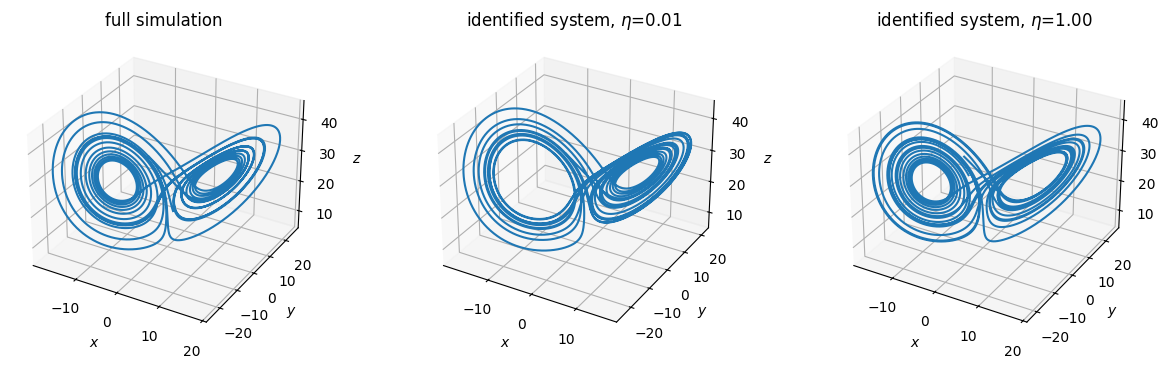

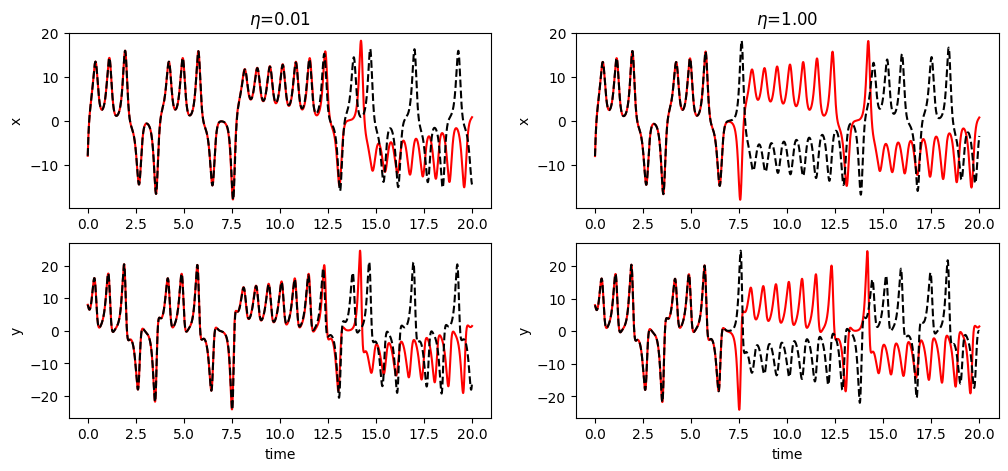

In [7]:
# Plot results
fig = plt.figure(figsize=(15, 4))
ax = fig.add_subplot(131, projection="3d")
ax.plot(
    x_train[: t_sim.size, 0],
    x_train[: t_sim.size, 1],
    x_train[: t_sim.size, 2],
)
plt.title("full simulation")
ax.set(xlabel="$x$", ylabel="$y$", zlabel="$z$")

model_idx = 2
ax = fig.add_subplot(132, projection="3d")
ax.plot(x_sim[model_idx][:, 0], x_sim[model_idx][:, 1], x_sim[model_idx][:, 2])
plt.title(f"identified system, $\eta$={noise_levels[model_idx]:.2f}")
ax.set(xlabel="$x$", ylabel="$y$", zlabel="$z$")

model_idx = 4
ax = fig.add_subplot(133, projection="3d")
ax.plot(x_sim[model_idx][:, 0], x_sim[model_idx][:, 1], x_sim[model_idx][:, 2])
plt.title(f"identified system, $\eta$={noise_levels[model_idx]:.2f}")
ax.set(xlabel="$x$", ylabel="$y$", zlabel="$z$")

fig = plt.figure(figsize=(12, 5))
model_idx = 2
ax = fig.add_subplot(221)
ax.plot(t_sim, x_train[: t_sim.size, 0], "r")
ax.plot(t_sim, x_sim[model_idx][:, 0], "k--")
plt.title(f"$\eta$={noise_levels[model_idx]:.2f}")
plt.ylabel("x")

ax = fig.add_subplot(223)
ax.plot(t_sim, x_train[: t_sim.size, 1], "r")
ax.plot(t_sim, x_sim[model_idx][:, 1], "k--")
plt.xlabel("time")
plt.ylabel("y")

model_idx = 4
ax = fig.add_subplot(222)
ax.plot(t_sim, x_train[: t_sim.size, 0], "r")
ax.plot(t_sim, x_sim[model_idx][:, 0], "k--")
plt.title(f"$\eta$={noise_levels[model_idx]:.2f}")
plt.ylabel("x")

ax = fig.add_subplot(224)
ax.plot(t_sim, x_train[: t_sim.size, 1], "r")
ax.plot(t_sim, x_sim[model_idx][:, 1], "k--")
plt.xlabel("time")
plt.ylabel("y")

fig.show()